# TD 7

## Identify the problem

Let's try to redo the RNN guessing the names' nationalities, with the full original dataset "names" instead of "names_1000".

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import torch
import torch.nn as nn
import torch.optim as optim
import unicodedata

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from unidecode import unidecode

Create alphabet, and dataset

In [14]:
# Our alphabet
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
N_LETTERS = len(LETTERS)

# Turn a Unicode string to string of characters in our alphabet
def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

# Turn a name into a <name_length x 1 x N_LETTERS>, or a tensor of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

# Create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# Split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# Create a dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Create the network & train it

In [15]:
# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')


Epoch: 1/5 (20%)	Loss: 19083.137617
Epoch: 2/5 (40%)	Loss: 15181.590310
Epoch: 3/5 (60%)	Loss: 14346.104622
Epoch: 4/5 (80%)	Loss: 13843.219033
Epoch: 5/5 (100%)	Loss: 13611.972855


Test the network

NAME; TRUTH; PREDICTED
Imai; Japanese; English
Lykhin; Russian; English
Kranz; German; English
Islamov; Russian; English
Boulos; Arabic; English
Stainton; English; English
Shamon; Arabic; English
Murase; Japanese; English
Saliba; Arabic; English
Kaufman; German; English

Accuracy: 72.08%


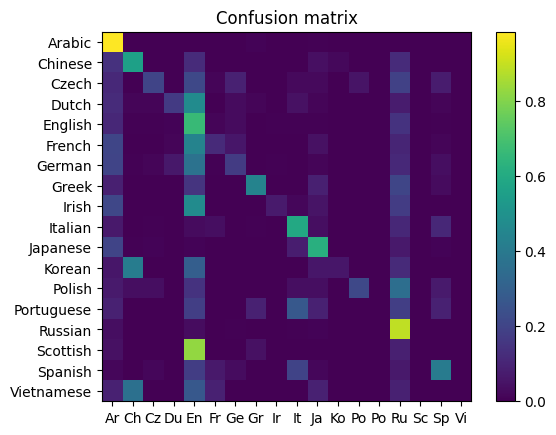

In [16]:
# Test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy increased! (~75% vs ~60% last time)

Let's try a couple of examples of our own:

In [17]:
names = ["Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; English
Santos; English
Yamamoto; English


It's almost always english/russian that is predicted!

This is typical of a class unbalance, let's investigate the size of each class:

In [18]:
# cout each country in the dataset
countr_count = {}
total = 0
for country in dataset.countries:
    countr_count[country] = countr_count.get(country, 0) + 1
    total += 1
countr_count, total

({'Arabic': 2000,
  'Chinese': 268,
  'Czech': 519,
  'Dutch': 297,
  'English': 3668,
  'French': 277,
  'German': 724,
  'Greek': 203,
  'Irish': 232,
  'Italian': 709,
  'Japanese': 991,
  'Korean': 94,
  'Polish': 139,
  'Portuguese': 74,
  'Russian': 9408,
  'Scottish': 100,
  'Spanish': 298,
  'Vietnamese': 73},
 20074)

---
---
---

## Fixing the unbalanced learning

As we did not want to bother you with unbalanced datasets yet as it was your first RNN, all 18 nationalities were represented with the same number of names in TD 6b. Now that we used `names.txt` instead of `names_1000.txt`, we have an unbalanced dataset. This is what real life looks like.

We ignored this but because the dataset was smaller from some nationalities, you can see that in the last TD's `Vietnamese.txt`, some names appeared several times, which is almost a way of artificially balancing the dataset.

### 1st fixing idea: modify the dataset

Instead of loading names one by one, choose a country at random, then choose a name at random from this category.
Do this using an iterable dataset (checkout the doc here: https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset).

In [19]:
import random
from torch.utils.data import IterableDataset

# Create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt'):
        # Read data
        self.names = dict()
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, country):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[country]] = 1
        return tensor

    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # Choose random country
        country = random.choice(self.idx_to_country)
        # Choose random name from this country
        name = random.choice(self.names[country])
        # Convert to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(country)
        return (name, country, name_tensor, countryID)
    
    def __len__(self):
        return 25000  # Arbitrary, size of one epoch

dataset = NamesIterableDataset('data/names/*.txt')
# Get a sample
name, country, name_tensor, country_tensor = next(dataset)
name, country, name_tensor.shape, country_tensor

('Panayiotopoulos', 'Greek', torch.Size([15, 1, 56]), tensor(7))

Re-define the RNN and re-train it with our new fancy iterable dataset.
Print the final accuracy, and plot the confusion matrix (which should be closer to the identity matrix).

In [1]:
N_COUNTRIES = dataset.n_countries

# Create a dataloader
train_loader = DataLoader(dataset, batch_size=1)  # batch_size 1 as names have different lengths
test_loader = DataLoader(dataset, batch_size=1)

# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# Train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for (name, country, name_tensor, country_tensor) in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# Test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_loader):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

NameError: name 'dataset' is not defined

Of course, the accuracy went down again, but at least, our RNN isn't biased.

Note that the training and testing set are the same, so the testing is still not solid.

---

### 2nd fixing idea: add a sampler to the dataloader

Reuse our previous dataset, and a sampler to the dataloader.
Checkout the doc [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler).

In [21]:
# Create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #  Read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# Split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# Create a dataloader
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
# Create a random sampler that counterbalances the classes
country_weights = torch.tensor([1/train_dataset.dataset.countries.count(country) for country in train_dataset.dataset.idx_to_country])
# Train
train_items_weights = torch.tensor(
    [country_weights[train_dataset.dataset.country_to_idx[country]]
    for i,country in enumerate(train_dataset.dataset.countries) if i in train_dataset.indices]
)
train_sampler = WeightedRandomSampler(train_items_weights, len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=1)
# Test
test_items_weights = torch.tensor([country_weights[test_dataset.dataset.country_to_idx[country]] \
    for i,country in enumerate(test_dataset.dataset.countries) if i in test_dataset.indices])
test_sampler = WeightedRandomSampler(test_items_weights, len(test_dataset), replacement=True)
test_loader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1)

Epoch: 1/5 (20%)	Loss: 18175.935034
Epoch: 2/5 (40%)	Loss: 13377.698049
Epoch: 3/5 (60%)	Loss: 11827.269914
Epoch: 4/5 (80%)	Loss: 11435.874881
Epoch: 5/5 (100%)	Loss: 11443.275437

NAME; TRUTH; PREDICTED
Worsnop; English; English
Liang; Chinese; English
Omalley; English; English
Yapondych; Russian; English
Wan; Chinese; English
Remeslo; Russian; English
Oirschotten; Dutch; English
Obydennov; Russian; English
Havronin; Russian; English
Aswad; Arabic; English

Accuracy: 71.63%


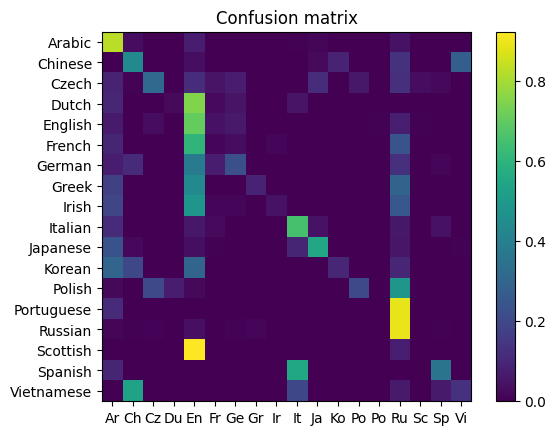

In [22]:
# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# Train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# Test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

In [ ]:
# Confusion matrix on training set
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in train_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(train_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix ON TRAINING SET')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy is higher, but the confusion matrix is more polarized; this technique only partially compensate for the class inbalance.

---

### 3rd fixing idea: weight the loss function

Reuse our previous dataset, dataloader, but modify the loss function to compensate the class sizes.
Checkout the doc here: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

Epoch: 1/5 (20%)	Loss: 19076.659558
Epoch: 2/5 (40%)	Loss: 15050.310365
Epoch: 3/5 (60%)	Loss: 14375.503568
Epoch: 4/5 (80%)	Loss: 13907.069344
Epoch: 5/5 (100%)	Loss: 13624.291385

NAME; TRUTH; PREDICTED
Bazilevitch; Russian; English
Inglefield; English; English
Warby; English; English
Kozlowski; Polish; English
Vu; Vietnamese; English
Kattan; Arabic; English
Isa; Arabic; English
Antipas; Greek; English
Nader; Arabic; English
Lezhava; Russian; English

Accuracy: 72.40%


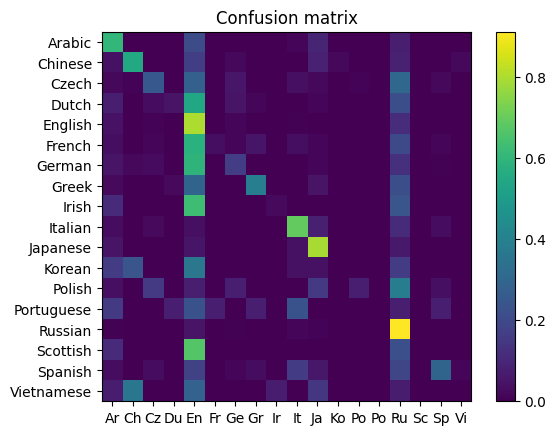

In [23]:
# Create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# Split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# Create a dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# Train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
country_weights = torch.tensor([1/train_dataset.dataset.countries.count(country) for country in train_dataset.dataset.idx_to_country])
criterion = nn.NLLLoss(country_weights)
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# Test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(test_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()


Accuracy: 74.01%


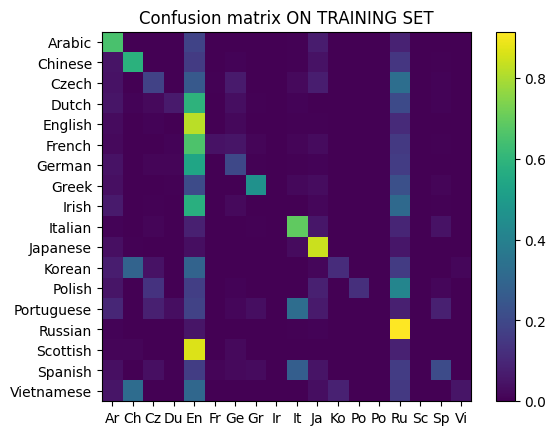

In [24]:
# Confusion matrix on training set
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in train_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# Accuracy
print(f'\nAccuracy: {100*accuracy/len(train_dataset):.2f}%')

# Plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix ON TRAINING SET')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()